In [26]:
#imports 
import random
import numpy as np
import pandas as pd
from scipy.stats import beta
from Bio.SubsMat import MatrixInfo
import matplotlib.pyplot as plt

In [28]:
# Helper functions

AA = list("ACDEFGHIKLMNPQRSTVWY")

# returns the spike protein from the FASTA as a string
def load_spike(fasta_path):
    """Read FASTA and return sequence string."""
    seq = []
    with open(fasta_path) as f:
        for line in f:
            if line.startswith(">"):
                continue
            seq.append(line.strip())
    return "".join(seq)



AA = list("ACDEFGHIKLMNPQRSTVWY")          # standard 20 amino acids
B62 = MatrixInfo.blosum62                 # dict of BLOSUM62 scores

def weight(orig, new):
    """positive weight = 2^(BLOSUM score); default to 2^-4 if pair missing"""
    if orig == new:
        return 0                          # we never substitute to the same AA
    score = B62.get((orig, new), B62.get((new, orig), -4))
    return 2 ** score

def mutate_sequence(seq, mu):
    """
    Choose k ~ Binomial(len(seq), mu) sites.
    For each chosen site, pick the replacement AA with probability
    proportional to 2^(BLOSUM62 score).
    """
    n = len(seq)
    k = np.random.binomial(n, mu)
    if k == 0:
        return seq

    seq_list = list(seq)

    for pos in random.sample(range(n), k):          # k distinct positions
        orig = seq_list[pos]

        # build candidate list and BLOSUM-based weights
        candidates = [aa for aa in AA if aa != orig]
        weights    = [weight(orig, aa) for aa in candidates]

        # draw one replacement, respecting the weights
        new_aa = random.choices(candidates, weights=weights, k=1)[0]
        seq_list[pos] = new_aa

    return "".join(seq_list)





In [30]:
def run_mc(spike_seq, epitope_set, num_trials, mu):
    # Pre-compute W = all known epitopes already in WT Spike
    wt_9mers = {spike_seq[i:i+9] for i in range(len(spike_seq) - 8)}
    W = wt_9mers & epitope_set            # set of baseline (WT-present) epitopes


    gain_trials = 0                       # how many trials gained ≥1 new epitope (more susceptible) 
    loss_trials = 0                       # how many trials lost ≥1 WT epitope (less susceptible) 
    net_changes = []                      # list of (#gained − #lost) for every trial
    gains = []
    losses = []

    # Monte Carlo 
    for count in range(num_trials):
        mutated = mutate_sequence(spike_seq, mu)        # mutate once
        mut_9mers = {mutated[i:i+9] for i in range(len(mutated) - 8)}
        hits = mut_9mers & epitope_set                  # all known epitopes in this mutant

        gained = hits - W                               # new epitopes not in WT
        lost   = W - hits                               # WT epitopes that disappeared

        if gained:                                      # flag “gain” trial
            gain_trials += 1
        if lost:                                        # flag “loss” trial
            loss_trials += 1
        gains.append(len(gained))
        losses.append(len(lost))
        net_changes.append(len(gained) - len(lost))     # could be pos, zero, or neg

    # Find Stats
    p_gain  = gain_trials / num_trials
    p_loss  = loss_trials / num_trials
    mean_nc = np.mean(net_changes)                      # mean net change

    return p_gain, p_loss, mean_nc, net_changes, gains, losses


def first_hit_cycles(spike_seq, epitope_set, mu, want_gain=True, max_cycles=100000):
    """
    Simulate mutation cycles until EITHER
        • at least one new epitope appears   (want_gain=True)   OR
        • at least one WT epitope disappears (want_gain=False)

    Returns the number of cycles required.  Stops after `max_cycles`
    """
    W = {spike_seq[i:i+9] for i in range(len(spike_seq) - 8)} & epitope_set
    seq = spike_seq
    for cycle in range(1, max_cycles + 1):
        seq = mutate_sequence(seq, mu)
        mut_9mers = {seq[i:i+9] for i in range(len(seq) - 8)}
        hits = mut_9mers & epitope_set

        gained = hits - W
        lost   = W - hits

        if  (want_gain and gained) or (not want_gain and lost):
            return cycle          
    return max_cycles              




def run_experiments(spike_seq, epitope_set, mu, n_exp=100):
    cycles_to_gain = []
    cycles_to_loss = []

    for count in range(n_exp):
        cycles_to_gain.append(
            first_hit_cycles(spike_seq, epitope_set, mu, want_gain=True)
        )
        cycles_to_loss.append(
            first_hit_cycles(spike_seq, epitope_set, mu, want_gain=False)
        )

    return cycles_to_gain, cycles_to_loss



def plot_cycles(cycles, title):
    plt.figure(figsize=(10,4))
    plt.plot(range(1, len(cycles)+1), cycles, lw=0.8)
    plt.xlabel("Experiment #")
    plt.ylabel("Cycles needed")
    plt.title(title)
    plt.tight_layout()

In [32]:

path = '/Users/adityakoushik/Downloads/epitope_table_export_1748931548.csv'
df = pd.read_csv(path)
df = df[['Epitope - Name']]
mask = df["Epitope - Name"].str.len() == 9
epitope_set = set(df.loc[mask, "Epitope - Name"].tolist())


In [34]:
# Adjust these paths as needed:
spike_fasta_path = "/Users/adityakoushik/Desktop/spike.fasta"


# Monte Carlo parameters:
N = 100000        # number of trials
mu = 1e-5         # per-site mutation rate


spike_seq = load_spike(spike_fasta_path)
print(f"Loaded spike (length {len(spike_seq)} aa), {len(epitope_set)} epitopes.")


p_gain, p_loss, mean_nc, net_changes, gains, losses = run_mc(spike_seq, epitope_set, N, mu)

print("Results:")
print(f"  Prob of gaining epitope: {p_gain}")
print(f"  Prob of losing epitope: {p_loss}")
print(f"  Mean num epitopes gained: {mean_nc}")



Loaded spike (length 1273 aa), 4222 epitopes.
Results:
  Prob of gaining epitope: 4e-05
  Prob of losing epitope: 0.01024
  Mean num epitopes gained: -0.0213


In [35]:
freq = pd.Series(net_changes).value_counts(sort=False)
freq1 = pd.Series(gains).value_counts(sort=False)
freq2 = pd.Series(losses).value_counts(sort=False)
print(freq)
print(freq1)
print(freq2)

 0    98976
-1      381
-2      354
-4       59
-3      196
-8        7
-5       13
-6        8
-7        3
-9        3
dtype: int64
0    99996
1        4
dtype: int64
0    98976
1      379
2      354
4       59
3      198
8        7
5       13
6        8
7        3
9        3
dtype: int64


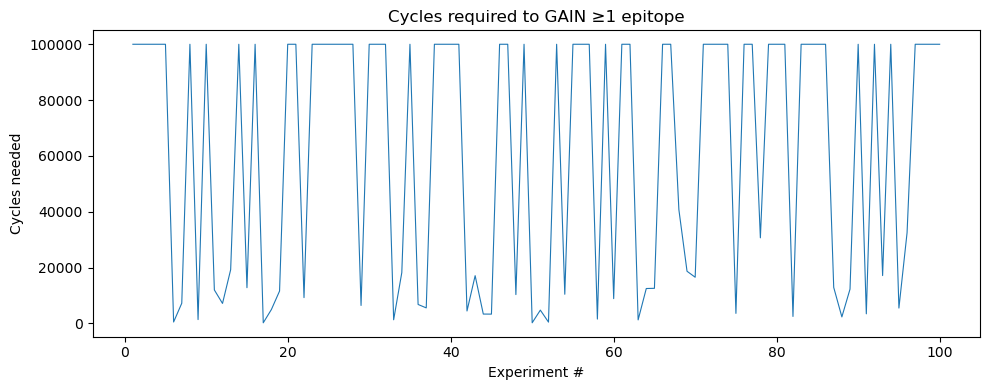

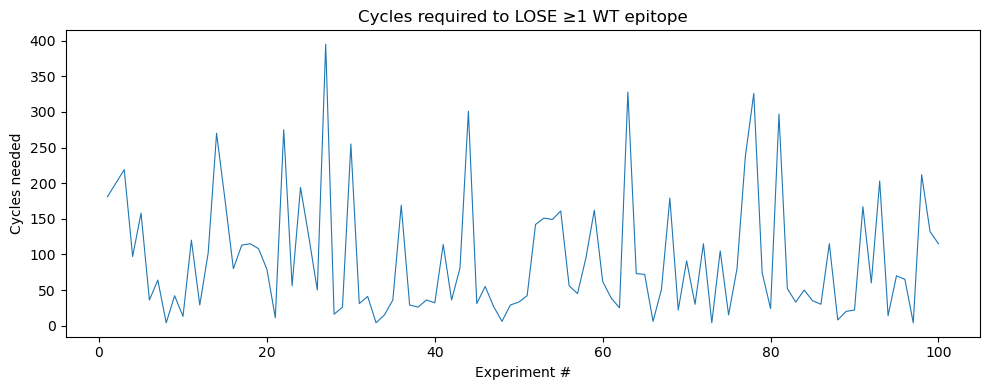

CPU times: user 16min 2s, sys: 9.29 s, total: 16min 11s
Wall time: 16min 18s


In [38]:
%%time
# Model as EXPONENTIAL/GEOMETRIC
# We dont look at net gain/loss, we just treat gaining an epitope and losing an epitope as seperate events 

cycles_gain, cycles_loss = run_experiments(spike_seq, epitope_set, mu)
plot_cycles(cycles_gain,  "Cycles required to GAIN ≥1 epitope")
plot_cycles(cycles_loss,  "Cycles required to LOSE ≥1 WT epitope")
plt.show()
